# Importação dos dados

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Configuração global para não usar notação científica
pd.set_option('display.float_format', '{:.4f}'.format)

## Funções

In [4]:
def filtrar_dataframe(df, coluna_filtro, valor_filtro):
    df = df[df[coluna_filtro] == valor_filtro]
    return df

In [5]:
def extracao_dados():
    urls = [
        "./base-de-dados/loja_1.csv",
        "./base-de-dados/loja_2.csv",
        "./base-de-dados/loja_3.csv",
        "./base-de-dados/loja_4.csv",
    ]
    
    lojas = []
    
    for u in urls:
        nome_loja = u.split("/")[-1].replace(".csv", "")
        loja = pd.read_csv(u)
        loja.insert(0, "Loja", nome_loja)
        lojas.append(loja)
    df = pd.concat(lojas, ignore_index=True)

    return df

In [6]:
def calculos_auxiliares(df):

    df['Receita'] = (df['Preço'] - df['Frete'])
    df['Perc_Frete_Faturamento'] = df['Frete'] / df['Preço'] *100

    # Custo avaliação
    # Valor ponderado da avaliação de acordo com o Preço de compra
    df['Custo_avaliacao'] = (5 - df['Avaliação da compra']) * df['Preço'] / 5
    #df['Custo_avaliacao'] = (1 - (df['Avaliação da compra'] / 5)) * df['Preço']

    # Validar coluna 'Data da Compra' no formato datetime
    df['Data da Compra'] = pd.to_datetime(df['Data da Compra'], format='%d/%m/%Y')
    df["Ano"] = df["Data da Compra"].dt.year
    df["Mês"] = df["Data da Compra"].dt.month
    df["Nome mês"] = df["Data da Compra"].dt.month_name()
    # Formato Ano-Mês
    df['Ano-Mês'] = df['Data da Compra'].dt.strftime('%Y-%m')

    return df

In [7]:
def calcular_percentuais(df):
    df['Perc_Frete_Faturamento'] = df['Frete'] / df['Faturamento'] *100
    df['Perc_Part_Faturamento'] = df['Faturamento'] / df['Faturamento'].sum() *100
    df['Perc_Part_Frete'] = df['Frete'] / df['Frete'].sum() *100
    df['Perc_Part_Receita'] = df['Receita'] / df['Receita'].sum() *100

    return df

In [8]:
def resumo_indicadores(df, nivel_detalhe:list=['Loja'], classificacao:list=['Faturamento'], ascendente:list=[True]):
    
    df_resumo = df.groupby(nivel_detalhe, as_index=False).agg(
        Faturamento = ('Preço', 'sum'),
        Frete = ('Frete', 'sum'),
        Receita = ('Receita', 'sum'),
        Media_avaliacao  = ('Avaliação da compra', 'mean'),
        Custo_avaliacao = ('Custo_avaliacao', 'sum'),
        Quant_compras = ('Preço', 'count'),
        Quant_meses  = ('Ano-Mês', 'nunique'),
    ).sort_values(by=classificacao, ascending=ascendente)

    df_resumo['Faturamento_medio'] = df_resumo['Faturamento'] / df_resumo['Quant_compras']
    
    df_resumo = calcular_percentuais(df_resumo)
    
    return df_resumo

In [9]:
def evolucao_periodica_valores(df, valor='Preço', periodo='Ano-Mês', coluna_valor='Faturamento', pivot_df=True):
    df_evolucao_valores = df.groupby(['Loja', periodo], as_index=False).agg({
        valor: 'sum',
    })

    # Renomeando as colunas
    df_evolucao_valores.columns = ['Loja', periodo, coluna_valor]
    
    if pivot_df:
        
        # Agora, vamos criar uma tabela pivot para transpor o período como colunas
        df_evolucao_valores = df_evolucao_valores.pivot(
            index='Loja',
            columns=periodo,
            values=coluna_valor
        )
        # Ordenar as colunas
        df_evolucao_valores = df_evolucao_valores.reindex(sorted(df_evolucao_valores.columns), axis=1)
        
        # Resetar o índice 
        df_evolucao_valores = df_evolucao_valores.reset_index()
        #df_evolucao_valores = df_evolucao_valores.rename_axis(columns=coluna_valor, index=None)
        df_evolucao_valores = df_evolucao_valores.rename_axis(columns=None, index=None)

    return df_evolucao_valores

In [10]:
def variacao_evolucao_periodica_valores(df):
    df_var = pd.DataFrame()
    df_var['Loja'] = df['Loja']
    
    # Lista de todos os anos em ordem
    periodos = list(df.columns[1:])
    
    # Para cada par de anos consecutivos
    for i in range(len(periodos)-1):
        periodo_atual = periodos[i]
        periodo_seguinte = periodos[i+1]
        coluna_variacao = f'%Var {periodo_atual}/{periodo_seguinte}'
        
        # Calcula a variação percentual
        df_var[coluna_variacao] = ((df[periodo_seguinte] - df[periodo_atual]) / df[periodo_atual] * 100).round(2)

    return df_var

In [11]:
def detalhamento_categoria_dados(df, coluna_categoria, coluna_metrica, colunas_dataframe=['Loja', 'Faturamento', 'Receita', 'Custo_avaliacao', 'Faturamento_medio']):
    
    valores_categoria = list(set(df[coluna_categoria]))
    valores_categoria.sort()
    print(f'\nForam idetificados {len(valores_categoria)} valores distintos na categoria de dados {coluna_categoria}\n')

    # Filtrar dataframe com colunas específicas
    colunas = colunas_dataframe.copy()
    colunas.insert(0, coluna_categoria)

    # print(f'Colunas dataframe {colunas}')
    
    df_temp = df[colunas]
    
    top_1_categoria = []
    
    for vc in valores_categoria:
        df_filtro = filtrar_dataframe(df_temp, coluna_categoria, vc)[0:]
        df_filtro[f'Perc_{coluna_metrica}'] = df_filtro[coluna_metrica] / df_filtro[coluna_metrica].sum() *100
        df_filtro = df_filtro.sort_values(by=coluna_metrica, ascending=False)
        
        # Selecionar a loja top 1 na categoria de dados definida
        top_1_categoria.append(df_filtro[0:1])
        
        print()
        display(df_filtro)

    print(f'\n\nLoja líder de {coluna_metrica} em cada uma das categorias de dados da coluna {coluna_categoria}\n')

    df_top_categoria = pd.concat(top_1_categoria)
    
    display(df_top_categoria)
    print(f'\n\nConsolidado por Loja líder de {coluna_metrica} em cada uma das categorias de dados da coluna {coluna_categoria}\n')
    
    df_agg = df_top_categoria.groupby(["Loja"], as_index=False).agg(
        Quantidade = ('Loja', 'count'),
        Faturamento = (coluna_metrica, 'sum'),
    ).sort_values(by=["Quantidade"], ascending=[False])
    display(df_agg)

In [12]:
def gerar_grafico_barras(df_plot, valor_x, valor_y, titulo, label_x, label_y, rotacao_x=0, tamanho=(16, 6)):
    
    # Criar o gráfico
    plt.figure(figsize=tamanho)
    plt.bar(df_plot[valor_x], df_plot[valor_y])
    
    # Adicionar elementos ao gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel(label_x, fontsize=12)
    plt.ylabel(label_y, fontsize=12)
    plt.xticks(rotation=rotacao_x) 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [13]:
def gerar_grafico_evolucao(df, titulo, label_x, label_y, index, rotacao_x=0, tamanho=(16, 6)):
    
    # Definir coluna de índice para facilitar o plot
    df_plot = df.set_index(index)
    
    # Definir eixo x
    anos = list(df.columns[1:])
    
    # Criar o gráfico
    plt.figure(figsize=tamanho)
    
    # Para cada loja, plotar uma linha
    for loja in df_plot.index:
        plt.plot(anos, df_plot.loc[loja, anos], marker='o', linewidth=1, label=loja)
    
    # Adicionar elementos ao gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel(label_x, fontsize=12)
    plt.ylabel(label_y, fontsize=12)
    plt.xticks(anos, rotation=rotacao_x) 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=index, loc='best', fontsize=10)

# 1. Extração de dados

In [14]:
df_lojas = extracao_dados()

In [15]:
df_lojas = calculos_auxiliares(df_lojas)

### Amostragem dados

In [16]:
df_lojas.head()

,Loja,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Receita,Perc_Frete_Faturamento,Custo_avaliacao,Ano,Mês,Nome mês,Ano-Mês
0,loja_1,Assistente virtual,eletronicos,219.0800,9.2498,2021-01-16,Pedro Gomes,SP,4,cartao_credito,8,-22.1900,-48.7900,209.8302,4.2221,43.8160,2021,1,January,2021-01
1,loja_1,Mesa de jantar,moveis,256.3500,11.2343,2022-05-18,Beatriz Moraes,RJ,1,cartao_credito,4,-22.2500,-42.6600,245.1157,4.3824,205.0800,2022,5,May,2022-05
2,loja_1,Jogo de tabuleiro,brinquedos,279.5100,21.2627,2021-03-15,João Souza,DF,1,cartao_credito,1,-15.8300,-47.8600,258.2473,7.6071,223.6080,2021,3,March,2021-03
3,loja_1,Micro-ondas,eletrodomesticos,1009.9900,54.6673,2022-05-03,João Souza,RS,4,boleto,1,-30.1700,-53.5000,955.3227,5.4127,201.9980,2022,5,May,2022-05
4,loja_1,Cadeira de escritório,moveis,446.9900,26.9647,2020-11-07,Larissa Alves,MG,5,boleto,1,-18.1000,-44.3800,420.0253,6.0325,0.0000,2020,11,November,2020-11


### Características dos dados

In [17]:
df_lojas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9435 entries, 0 to 9434
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Loja                    9435 non-null   object        
 1   Produto                 9435 non-null   object        
 2   Categoria do Produto    9435 non-null   object        
 3   Preço                   9435 non-null   float64       
 4   Frete                   9435 non-null   float64       
 5   Data da Compra          9435 non-null   datetime64[ns]
 6   Vendedor                9435 non-null   object        
 7   Local da compra         9435 non-null   object        
 8   Avaliação da compra     9435 non-null   int64         
 9   Tipo de pagamento       9435 non-null   object        
 10  Quantidade de parcelas  9435 non-null   int64         
 11  lat                     9435 non-null   float64       
 12  lon                     9435 non-null   float64 

# 2. Análise de indicadores por Loja

In [18]:
df_resumo_loja = resumo_indicadores(df_lojas, nivel_detalhe=['Loja'], classificacao=['Faturamento'], ascendente=[False])

In [19]:
df_resumo_loja.head()

,Loja,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
0,loja_1,1534509.1200,81837.9678,1452671.1522,3.9767,302810.7200,2359,39,650.4914,5.3332,26.1349,26.1521,26.1339
1,loja_2,1488459.0600,79314.1580,1409144.9020,4.0373,282287.6920,2359,39,630.9704,5.3286,25.3506,25.3456,25.3509
2,loja_3,1464025.0300,78022.6612,1386002.3688,4.0483,281270.4520,2359,39,620.6126,5.3293,24.9345,24.9329,24.9346
3,loja_4,1384497.5800,73755.8751,1310741.7049,3.9958,287943.7660,2358,39,587.1491,5.3273,23.5800,23.5694,23.5806


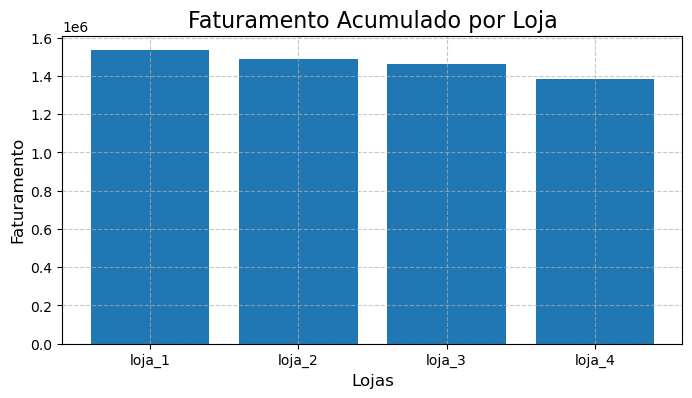

In [20]:
gerar_grafico_barras(df_resumo_loja, 'Loja', 'Faturamento', 'Faturamento Acumulado por Loja', 'Lojas', 'Faturamento', tamanho=(8,4))

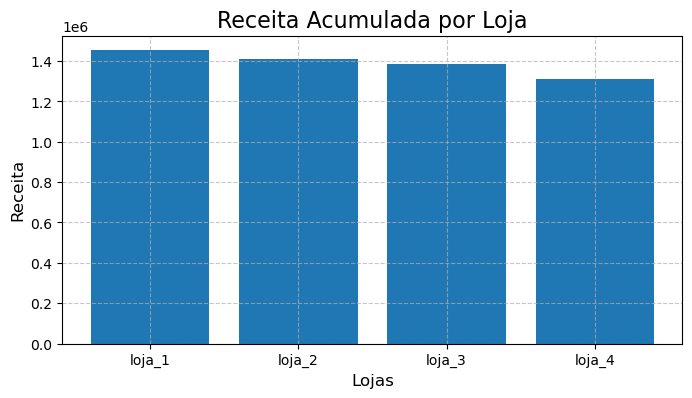

In [21]:
gerar_grafico_barras(df_resumo_loja, 'Loja', 'Receita', 'Receita Acumulada por Loja', 'Lojas', 'Receita', tamanho=(8,4))

# 3. Análise de indicadores por Loja e Categoria

In [22]:
df_resumo_loja_cat = resumo_indicadores(df_lojas, nivel_detalhe=['Loja', 'Categoria do Produto'], classificacao=['Loja', 'Faturamento'], ascendente=[True, False])

### Amostragem de dados

In [23]:
df_resumo_loja_cat.head()

,Loja,Categoria do Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
2,loja_1,eletronicos,572659.2300,30619.0087,542040.2213,4.0045,111377.5120,448,39,1278.2572,5.3468,9.7532,9.7846,9.7515
1,loja_1,eletrodomesticos,484913.3600,25764.9606,459148.3994,4.0321,92934.1340,312,39,1554.2095,5.3133,8.2588,8.2334,8.2602
6,loja_1,moveis,250178.1100,13327.2073,236850.9027,3.9462,53829.5400,465,39,538.0174,5.3271,4.2609,4.2588,4.2610
4,loja_1,instrumentos musicais,121731.6900,6511.8059,115219.8841,4.0495,22331.5640,182,39,668.8554,5.3493,2.0733,2.0809,2.0728
3,loja_1,esporte e lazer,52387.5500,2829.1076,49558.4424,3.8979,11137.1980,284,39,184.4632,5.4003,0.8922,0.9041,0.8916


### Ranking de Faturamento por Categoria do Produto

In [24]:
detalhamento_categoria_dados(df_resumo_loja_cat, 'Categoria do Produto', 'Faturamento')


Foram idetificados 8 valores distintos na categoria de dados Categoria do Produto




,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
24,brinquedos,loja_4,27015.6700,25532.6728,4956.0260,79.9280,27.5274
16,brinquedos,loja_3,25869.2000,24479.8017,3462.1060,82.1244,26.3593
0,brinquedos,loja_1,23993.7800,22688.2940,4335.5860,74.0549,24.4483
8,brinquedos,loja_2,21262.2100,20078.5912,4246.9900,67.9304,21.6650


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
1,eletrodomesticos,loja_1,484913.3600,459148.3994,92934.1340,1554.2095,27.4530
9,eletrodomesticos,loja_2,464758.1300,440017.1310,85548.7080,1523.7971,26.3120
17,eletrodomesticos,loja_3,438984.8900,415659.3164,82458.2240,1579.0823,24.8528
25,eletrodomesticos,loja_4,377680.6500,357650.5495,81278.0420,1486.9317,21.3821


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
2,eletronicos,loja_1,572659.2300,542040.2213,111377.5120,1278.2572,25.8642
10,eletronicos,loja_2,547773.7100,518689.1452,109261.4100,1298.0420,24.7402
18,eletronicos,loja_3,547699.9200,518559.4513,108664.9440,1214.4122,24.7369
26,eletronicos,loja_4,545966.8600,516862.5393,114754.5960,1210.5695,24.6586


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
3,esporte e lazer,loja_1,52387.5500,49558.4424,11137.1980,184.4632,27.4805
19,esporte e lazer,loja_3,47456.1000,44891.5823,10980.5800,171.3217,24.8936
11,esporte e lazer,loja_2,46326.0900,43823.2831,5967.9540,168.4585,24.3009
27,esporte e lazer,loja_4,44465.6500,42105.5286,9058.1020,160.5258,23.3250


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
12,instrumentos musicais,loja_2,139987.0300,132576.9692,28587.4220,624.9421,30.1028
4,instrumentos musicais,loja_1,121731.6900,115219.8841,22331.5640,668.8554,26.1772
20,instrumentos musicais,loja_3,103174.4500,97696.3553,20071.8280,582.9065,22.1866
28,instrumentos musicais,loja_4,100136.5000,94864.6505,19311.6580,589.0382,21.5334


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
13,livros,loja_2,13454.3500,12712.8636,2821.7080,68.2962,26.7691
21,livros,loja_3,12664.7000,12003.0224,2587.9500,68.4578,25.1980
29,livros,loja_4,12427.7700,11706.7327,2414.9960,66.4587,24.7266
5,livros,loja_1,11713.9200,11091.4298,2428.3660,67.7105,23.3063


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
22,moveis,loja_3,268095.5600,253715.8852,49472.1040,537.2657,26.5385
30,moveis,loja_4,256705.6500,243059.1355,52283.4540,534.8034,25.4110
6,moveis,loja_1,250178.1100,236850.9027,53829.5400,538.0174,24.7649
14,moveis,loja_2,235234.6800,222652.3105,42566.5720,532.2052,23.2856


,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
31,utilidades domesticas,loja_4,20098.8300,18959.8961,3886.8920,99.9942,26.1794
23,utilidades domesticas,loja_3,20080.2100,18996.9541,3572.7160,113.4475,26.1552
15,utilidades domesticas,loja_2,19662.8600,18594.6083,3286.9280,108.6346,25.6116
7,utilidades domesticas,loja_1,16931.4800,16073.5784,4436.8200,99.0145,22.0538




Loja líder de Faturamento em cada uma das categorias de dados da coluna Categoria do Produto



,Categoria do Produto,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
24,brinquedos,loja_4,27015.6700,25532.6728,4956.0260,79.9280,27.5274
1,eletrodomesticos,loja_1,484913.3600,459148.3994,92934.1340,1554.2095,27.4530
2,eletronicos,loja_1,572659.2300,542040.2213,111377.5120,1278.2572,25.8642
3,esporte e lazer,loja_1,52387.5500,49558.4424,11137.1980,184.4632,27.4805
12,instrumentos musicais,loja_2,139987.0300,132576.9692,28587.4220,624.9421,30.1028
13,livros,loja_2,13454.3500,12712.8636,2821.7080,68.2962,26.7691
22,moveis,loja_3,268095.5600,253715.8852,49472.1040,537.2657,26.5385
31,utilidades domesticas,loja_4,20098.8300,18959.8961,3886.8920,99.9942,26.1794




Consolidado por Loja líder de Faturamento em cada uma das categorias de dados da coluna Categoria do Produto



,Loja,Quantidade,Faturamento
0,loja_1,3,1109960.1400
1,loja_2,2,153441.3800
3,loja_4,2,47114.5000
2,loja_3,1,268095.5600


## 3.1. Análise Evolução de Faturamento

### Faturamento Mensal

In [25]:
df_faturamento_ano_mes = evolucao_periodica_valores(df_lojas, valor='Preço', periodo='Ano-Mês', coluna_valor='Faturamento', pivot_df=True)

In [26]:
df_faturamento_ano_mes

,Loja,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
0,loja_1,44112.7000,53405.5400,42083.0200,44888.3400,51443.8000,35062.2400,46780.6600,41501.8000,40324.7900,...,33313.0400,36334.7900,37061.3500,49481.0400,19576.0400,31541.9500,45602.5700,38573.5900,49637.1800,49470.6900
1,loja_2,41505.5300,23184.9700,40687.9200,36862.3100,33949.4200,34741.6200,31396.3900,31297.1700,41504.6900,...,31665.3700,31502.8400,38903.7900,43742.3400,40580.6500,37452.9100,44480.6100,33534.0700,45558.0800,36154.2100
2,loja_3,31710.5400,36769.8100,40033.1900,47124.4500,34831.2300,23285.2700,44803.3300,34500.9100,35557.9000,...,33864.1800,40976.2800,37062.6200,39136.7000,37206.4400,39951.7300,39621.9500,29931.9100,23670.3000,30290.1200
3,loja_4,25731.9100,30507.4900,38044.3500,52656.7000,42654.9100,35804.3600,35899.6800,41609.7100,37599.7400,...,30109.2600,19827.4600,35734.0900,41315.4400,26127.6400,38134.0800,25525.2200,26395.7900,26203.5100,24044.2600


In [27]:
# Seleciona Lojas
primeira_coluna = df_faturamento_ano_mes.iloc[:, 0]

# Seleciona os 12 últimos meses
ultimas_12_colunas = df_faturamento_ano_mes.iloc[:, -12:]

# Concatena as colunas selecionadas
df_faturamento_ultimos_12_mes = pd.concat([primeira_coluna, ultimas_12_colunas], axis=1)


In [28]:
df_faturamento_ultimos_12_mes

,Loja,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
0,loja_1,29845.0000,33463.8700,33313.0400,36334.7900,37061.3500,49481.0400,19576.0400,31541.9500,45602.5700,38573.5900,49637.1800,49470.6900
1,loja_2,46150.3400,46300.8200,31665.3700,31502.8400,38903.7900,43742.3400,40580.6500,37452.9100,44480.6100,33534.0700,45558.0800,36154.2100
2,loja_3,37819.0900,42567.6200,33864.1800,40976.2800,37062.6200,39136.7000,37206.4400,39951.7300,39621.9500,29931.9100,23670.3000,30290.1200
3,loja_4,27652.5800,28014.0400,30109.2600,19827.4600,35734.0900,41315.4400,26127.6400,38134.0800,25525.2200,26395.7900,26203.5100,24044.2600


### % De Variação no Faturamento em Relação ao Mês Anterior

In [29]:
df_var_faturamento_ultimos_12_mes = variacao_evolucao_periodica_valores(df_faturamento_ultimos_12_mes)

In [30]:
df_var_faturamento_ultimos_12_mes

,Loja,%Var 2022-04/2022-05,%Var 2022-05/2022-06,%Var 2022-06/2022-07,%Var 2022-07/2022-08,%Var 2022-08/2022-09,%Var 2022-09/2022-10,%Var 2022-10/2022-11,%Var 2022-11/2022-12,%Var 2022-12/2023-01,%Var 2023-01/2023-02,%Var 2023-02/2023-03
0,loja_1,12.1300,-0.4500,9.0700,2.0000,33.5100,-60.4400,61.1300,44.5800,-15.4100,28.6800,-0.3400
1,loja_2,0.3300,-31.6100,-0.5100,23.4900,12.4400,-7.2300,-7.7100,18.7600,-24.6100,35.8600,-20.6400
2,loja_3,12.5600,-20.4500,21.0000,-9.5500,5.6000,-4.9300,7.3800,-0.8300,-24.4600,-20.9200,27.9700
3,loja_4,1.3100,7.4800,-34.1500,80.2300,15.6200,-36.7600,45.9500,-33.0600,3.4100,-0.7300,-8.2400


### Faturamento Anual

In [31]:
df_faturamento_ano = evolucao_periodica_valores(df_lojas, valor='Preço', periodo='Ano', coluna_valor='Faturamento', pivot_df=True)

In [32]:
df_faturamento_ano

,Loja,2020,2021,2022,2023
0,loja_1,491911.5100,482829.9100,422086.2400,137681.4600
1,loja_2,427288.2500,468288.8900,477635.5600,115246.3600
2,loja_3,428943.0900,483938.9100,467250.7000,83892.3300
3,loja_4,441129.5200,463763.2700,402961.2300,76643.5600


### % De Variação no Faturamento em Relação ao Ano Anterior

In [33]:
df_var_faturamento_ano = variacao_evolucao_periodica_valores(df_faturamento_ano)

In [34]:
df_var_faturamento_ano

,Loja,%Var 2020/2021,%Var 2021/2022,%Var 2022/2023
0,loja_1,-1.8500,-12.5800,-67.3800
1,loja_2,9.6000,2.0000,-75.8700
2,loja_3,12.8200,-3.4500,-82.0500
3,loja_4,5.1300,-13.1100,-80.9800


### Gráfico de Evolução de Faturamento

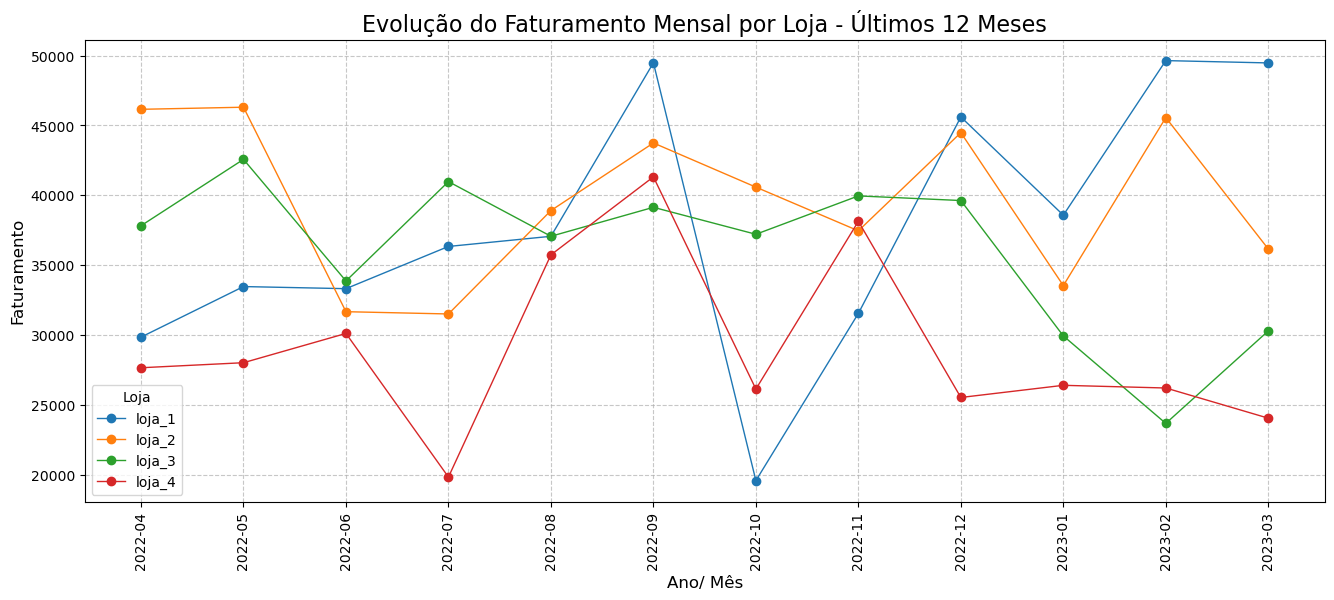

In [35]:
gerar_grafico_evolucao(df_faturamento_ultimos_12_mes, 'Evolução do Faturamento Mensal por Loja - Últimos 12 Meses', 'Ano/ Mês', 'Faturamento', 'Loja', rotacao_x=90)

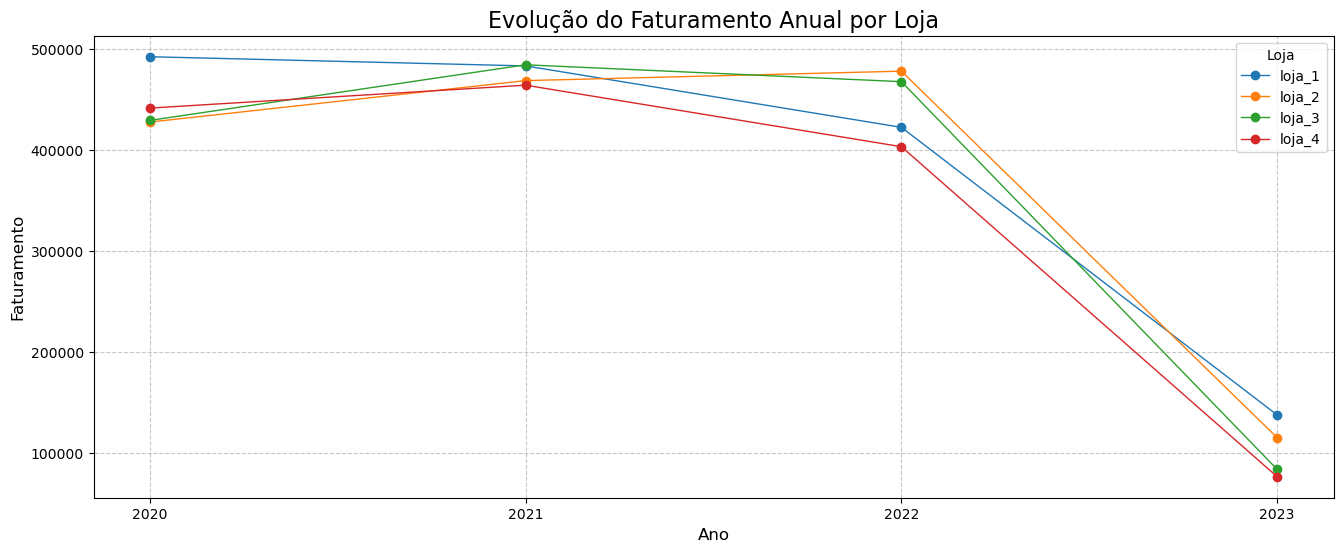

In [36]:
gerar_grafico_evolucao(df_faturamento_ano, 'Evolução do Faturamento Anual por Loja', 'Ano', 'Faturamento', 'Loja')

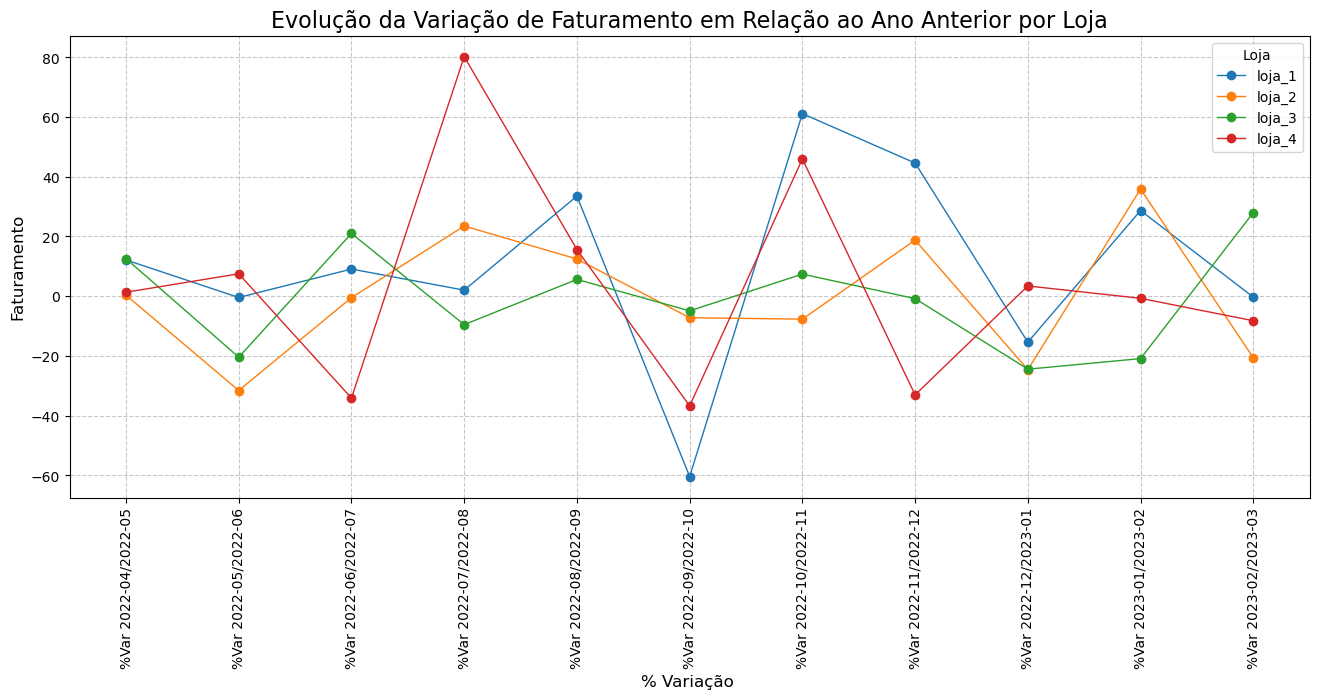

In [37]:
gerar_grafico_evolucao(df_var_faturamento_ultimos_12_mes, 'Evolução da Variação de Faturamento em Relação ao Ano Anterior por Loja', '% Variação ', 'Faturamento', 'Loja', rotacao_x=90)

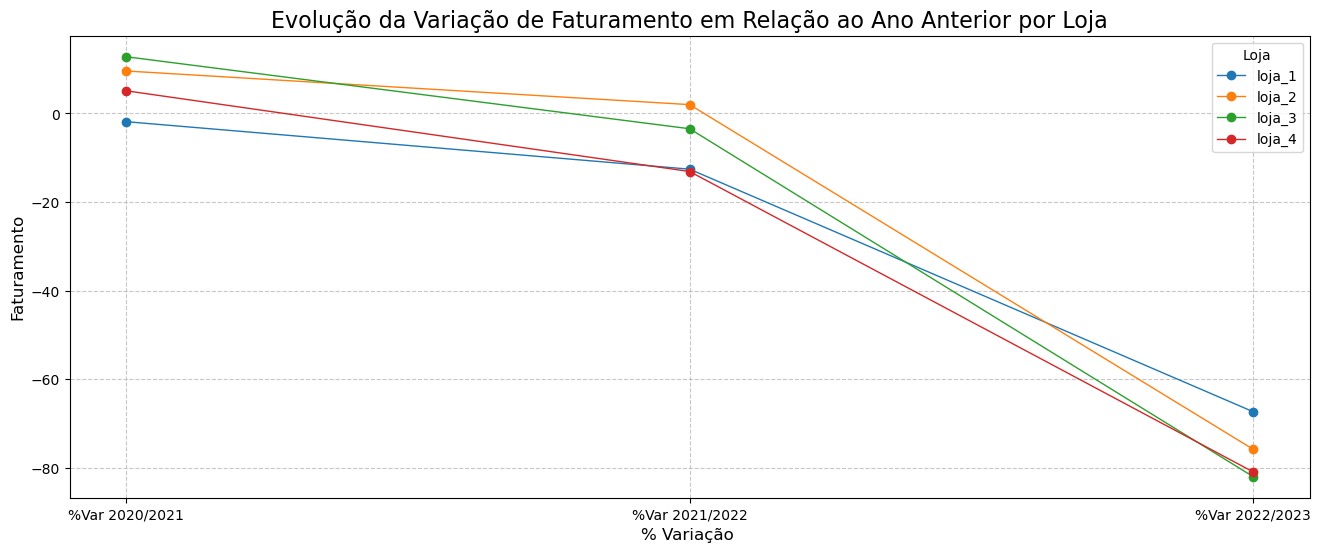

In [38]:
gerar_grafico_evolucao(df_var_faturamento_ano, 'Evolução da Variação de Faturamento em Relação ao Ano Anterior por Loja', '% Variação ', 'Faturamento', 'Loja')

# 4. Média de Avaliação das Lojas

> Foi criado uma métrica ponderada para avaliação das compras de acordo com a avaliação e o preço da compra

> Por exemplo, em uma compra de 100.00 e uma avalição 4 de 5, o Custo da Avaliação foi de 20.00

> Uma vez que a perde em relação a avaliação máxima (5) é de 20%

> 1 - (4 / 5) * 100.00 = 20.00

In [39]:
df_resumo_loja[['Loja', 'Media_avaliacao', 'Custo_avaliacao']]

,Loja,Media_avaliacao,Custo_avaliacao
0,loja_1,3.9767,302810.7200
1,loja_2,4.0373,282287.6920
2,loja_3,4.0483,281270.4520
3,loja_4,3.9958,287943.7660


In [40]:
df_temp = df_resumo_loja[['Loja', 'Media_avaliacao', 'Custo_avaliacao']].sort_values(by='Media_avaliacao', ascending=False)

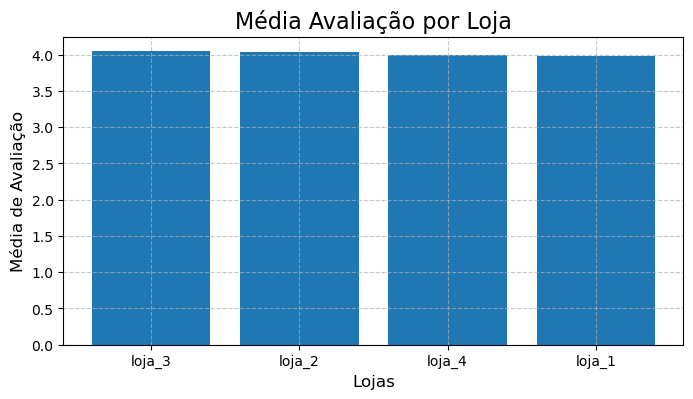

In [41]:
gerar_grafico_barras(df_temp, 'Loja', 'Media_avaliacao', 'Média Avaliação por Loja', 'Lojas', 'Média de Avaliação', tamanho=(8,4))

In [42]:
df_temp = df_resumo_loja[['Loja', 'Media_avaliacao', 'Custo_avaliacao']].sort_values(by='Custo_avaliacao', ascending=True)

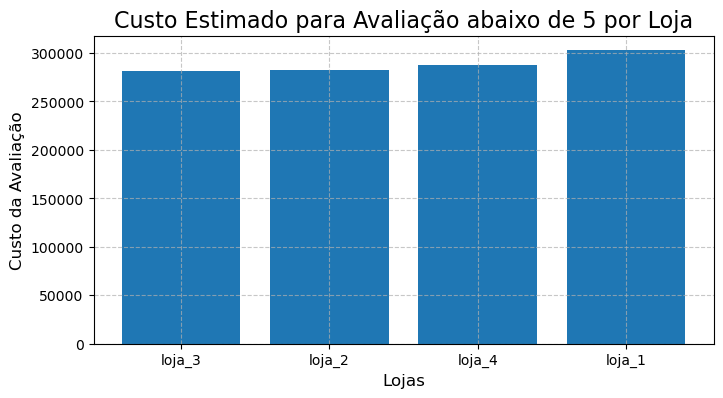

In [43]:
gerar_grafico_barras(df_temp, 'Loja', 'Custo_avaliacao', 'Custo Estimado para Avaliação abaixo de 5 por Loja', 'Lojas', 'Custo da Avaliação', tamanho=(8,4))

# 5. Produtos Mais e Menos Vendidos

## 5.1 Produto mais e menos vendidos por loja

In [44]:
lojas = ['loja_1', 'loja_2', 'loja_3', 'loja_4']

In [45]:
df_resumo_loja_prod = resumo_indicadores(df_lojas, nivel_detalhe=['Loja', 'Produto'], classificacao=['Faturamento'], ascendente=[False])

### Amostra dos dados

In [46]:
df_resumo_loja_prod.head(5)

,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
47,loja_1,TV Led UHD 4K,189534.2800,10121.5495,179412.7305,4.0500,35133.5960,60,30,3158.9047,5.3402,3.2280,3.2344,3.2277
63,loja_2,Celular Plus X42,150967.8300,8039.5143,142928.3157,3.8000,34905.0240,55,29,2744.8696,5.3253,2.5712,2.5691,2.5713
23,loja_1,Geladeira,149524.2800,7975.8192,141548.4608,4.0185,28138.4340,54,29,2768.9681,5.3341,2.5466,2.5487,2.5465
98,loja_2,TV Led UHD 4K,137833.0600,7337.0672,130495.9928,4.0889,23932.3040,45,28,3062.9569,5.3232,2.3475,2.3446,2.3477
125,loja_3,Geladeira,133185.9900,7057.6241,126128.3659,4.4200,15446.1240,50,27,2663.7198,5.2991,2.2684,2.2553,2.2691


### Top 20 Produtos Vendidos

In [47]:
df_resumo_loja_prod.head(20).groupby(["Loja"], as_index=False).agg(
    Quant_produtos = ('Loja', 'count'),
).sort_values(by=["Quant_produtos"], ascending=[False])

,Loja,Quant_produtos
0,loja_1,6
1,loja_2,5
2,loja_3,5
3,loja_4,4


### Top 100 Produtos Vendidos

In [48]:
df_resumo_loja_prod.head(100).groupby(["Loja"], as_index=False).agg(
    Quant_produtos = ('Loja', 'count'),
).sort_values(by=["Quant_produtos"], ascending=[False])

,Loja,Quant_produtos
2,loja_3,26
3,loja_4,26
0,loja_1,25
1,loja_2,23


### Mais vendidos por Loja

In [49]:
for l in lojas:
    display(filtrar_dataframe(df_resumo_loja_prod, 'Loja', l).head(5))

,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
47,loja_1,TV Led UHD 4K,189534.2800,10121.5495,179412.7305,4.0500,35133.5960,60,30,3158.9047,5.3402,3.2280,3.2344,3.2277
23,loja_1,Geladeira,149524.2800,7975.8192,141548.4608,4.0185,28138.4340,54,29,2768.9681,5.3341,2.5466,2.5487,2.5465
12,loja_1,Celular Plus X42,130536.4000,6985.1740,123551.2260,3.9388,27371.3720,49,28,2664.0082,5.3511,2.2232,2.2322,2.2227
44,loja_1,Smart TV,89936.1500,4806.5551,85129.5949,4.0000,17483.2820,44,28,2044.0034,5.3444,1.5317,1.5360,1.5315
34,loja_1,Lavadora de roupas,87711.3000,4641.5236,83069.7764,4.1277,15454.1260,47,27,1866.1979,5.2918,1.4939,1.4832,1.4944


,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
63,loja_2,Celular Plus X42,150967.8300,8039.5143,142928.3157,3.8000,34905.0240,55,29,2744.8696,5.3253,2.5712,2.5691,2.5713
98,loja_2,TV Led UHD 4K,137833.0600,7337.0672,130495.9928,4.0889,23932.3040,45,28,3062.9569,5.3232,2.3475,2.3446,2.3477
74,loja_2,Geladeira,130176.4800,6921.7673,123254.7127,4.2245,20711.6680,49,27,2656.6629,5.3172,2.2171,2.2119,2.2174
85,loja_2,Lavadora de roupas,89016.8100,4756.6382,84260.1718,3.7347,22253.2800,49,26,1816.6696,5.3435,1.5161,1.5200,1.5159
95,loja_2,Smart TV,81522.9400,4346.8046,77176.1354,3.9750,16104.8900,40,29,2038.0735,5.3320,1.3885,1.3891,1.3884


,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
125,loja_3,Geladeira,133185.9900,7057.6241,126128.3659,4.4200,15446.1240,50,27,2663.7198,5.2991,2.2684,2.2553,2.2691
149,loja_3,TV Led UHD 4K,128892.1100,6861.9279,122030.1821,4.2143,21498.7780,42,26,3068.8598,5.3238,2.1952,2.1928,2.1954
114,loja_3,Celular Plus X42,124300.8400,6644.6338,117656.2062,4.0435,23041.7820,46,26,2702.1922,5.3456,2.1170,2.1234,2.1167
146,loja_3,Smart TV,105116.4600,5557.2219,99559.2381,3.8519,24278.8880,54,29,1946.6011,5.2867,1.7903,1.7759,1.7911
135,loja_3,Lava louças,85819.7300,4561.5248,81258.2052,3.8462,19376.0640,52,27,1650.3794,5.3152,1.4616,1.4577,1.4619


,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
165,loja_4,Celular Plus X42,128930.0700,6856.4212,122073.6488,4.0833,22972.9440,48,25,2686.0431,5.3179,2.1959,2.1910,2.1961
200,loja_4,TV Led UHD 4K,120393.2500,6393.9777,113999.2723,3.5750,35305.0040,40,22,3009.8313,5.3109,2.0505,2.0433,2.0509
197,loja_4,Smart TV,110387.5700,5876.4612,104511.1088,4.0370,20625.2380,54,31,2044.2143,5.3235,1.8801,1.8779,1.8802
176,loja_4,Geladeira,100362.5900,5318.4618,95044.1282,3.9474,21021.6160,38,25,2641.1208,5.2992,1.7093,1.6996,1.7099
201,loja_4,Tablet ABXY,75630.7500,4069.2716,71561.4784,4.0222,13333.5460,45,28,1680.6833,5.3804,1.2881,1.3004,1.2874


### Menos vendidos por Loja

In [50]:
for l in lojas:
    display(filtrar_dataframe(df_resumo_loja_prod, 'Loja', l).tail(5))

,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
50,loja_1,Xadrez de madeira,1907.4200,110.5302,1796.8898,4.4286,212.0540,49,28,38.9269,5.7947,0.0325,0.0353,0.0323
29,loja_1,Jogo de copos,1812.1500,94.8337,1717.3163,3.2927,625.5380,41,24,44.1988,5.2332,0.0309,0.0303,0.0309
16,loja_1,Cubo mágico 8x8,929.2700,53.5707,875.6993,4.0682,165.4660,44,24,21.1198,5.7648,0.0158,0.0171,0.0158
19,loja_1,Dinossauro Rex,918.4000,93.0923,825.3077,3.7750,222.8540,40,28,22.9600,10.1364,0.0156,0.0297,0.0148
15,loja_1,Corda de pular,870.8900,110.2153,760.6747,3.6250,234.2540,40,26,21.7722,12.6555,0.0148,0.0352,0.0137


,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
80,loja_2,Jogo de copos,2056.6900,134.1647,1922.5253,4.0217,402.0520,46,29,44.7107,6.5233,0.0350,0.0429,0.0346
101,loja_2,Xadrez de madeira,1717.0500,104.1239,1612.9261,4.1111,287.9480,45,24,38.1567,6.0641,0.0292,0.0333,0.0290
66,loja_2,Corda de pular,1142.5400,98.2826,1044.2574,4.0400,225.7240,50,27,22.8508,8.6021,0.0195,0.0314,0.0188
70,loja_2,Dinossauro Rex,1027.4100,55.4162,971.9938,4.3333,129.0040,42,24,24.4621,5.3938,0.0175,0.0177,0.0175
67,loja_2,Cubo mágico 8x8,858.2200,95.1723,763.0477,3.6222,221.8520,45,32,19.0716,11.0895,0.0146,0.0304,0.0137


,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
105,loja_3,Blocos de montar,1649.8100,68.3035,1581.5065,4.3429,210.6040,35,26,47.1374,4.1401,0.0281,0.0218,0.0285
131,loja_3,Jogo de copos,1614.2000,96.7014,1517.4986,4.0278,317.8460,36,26,44.8389,5.9907,0.0275,0.0309,0.0273
117,loja_3,Corda de pular,1137.7600,71.8657,1065.8943,3.9057,246.0360,53,30,21.4672,6.3164,0.0194,0.0230,0.0192
121,loja_3,Dinossauro Rex,1060.7800,80.3849,980.3951,4.0870,206.5980,46,26,23.0604,7.5779,0.0181,0.0257,0.0176
118,loja_3,Cubo mágico 8x8,853.8100,60.7078,793.1022,4.1818,136.5540,44,25,19.4048,7.1102,0.0145,0.0194,0.0143


,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
182,loja_4,Jogo de copos,1962.2400,156.9256,1805.3144,4.0435,359.4120,46,28,42.6574,7.9973,0.0334,0.0501,0.0325
203,loja_4,Xadrez de madeira,1434.0900,84.9657,1349.1243,4.0000,293.3900,39,26,36.7715,5.9247,0.0244,0.0272,0.0243
172,loja_4,Dinossauro Rex,1143.9400,114.2128,1029.7272,4.0000,236.0800,47,26,24.3391,9.9842,0.0195,0.0365,0.0185
169,loja_4,Cubo mágico 8x8,997.3800,73.8693,923.5107,3.8511,239.8680,47,28,21.2209,7.4063,0.0170,0.0236,0.0166
168,loja_4,Corda de pular,939.7400,71.9856,867.7544,4.2791,134.7460,43,24,21.8544,7.6602,0.0160,0.0230,0.0156


## 5.2 Produto mais e menos vendidos geral

In [51]:
df_resumo_prod = df_lojas.groupby(["Produto"], as_index=False).agg(
    Faturamento = ('Preço', 'sum'),
    Quant_compras = ('Preço', 'count'),
).sort_values(by=["Faturamento"], ascending=[False])

In [52]:
df_resumo_prod['Faturamento_medio'] = df_resumo_prod['Faturamento'] / df_resumo_prod['Quant_compras']

In [53]:
df_resumo_prod.head(10)

,Produto,Faturamento,Quant_compras,Faturamento_medio
47,TV Led UHD 4K,576652.7000,187,3083.7043
12,Celular Plus X42,534735.1400,198,2700.6825
23,Geladeira,513249.3400,191,2687.1693
44,Smart TV,386963.1200,192,2015.4329
34,Lavadora de roupas,323292.3700,176,1836.8885
33,Lava louças,320715.5800,189,1696.9078
48,Tablet ABXY,292016.7600,179,1631.3785
43,Secadora de roupas,280317.3100,200,1401.5865
11,Celular ABXY,210547.7700,157,1341.0686
1,Bateria,197074.4500,203,970.8101


In [54]:
df_resumo_prod.tail(10)

,Produto,Faturamento,Quant_compras,Faturamento_medio
6,Boneca bebê,11456.0500,175,65.4631
20,Faqueiro,11413.8500,189,60.3907
14,Copo térmico,11329.8400,187,60.5874
3,Blocos de montar,9069.8600,199,45.5772
18,Dashboards com Power BI,8557.8800,181,47.2811
29,Jogo de copos,7445.2800,169,44.0549
50,Xadrez de madeira,6865.9000,180,38.1439
19,Dinossauro Rex,4150.5300,175,23.7173
15,Corda de pular,4090.9300,186,21.9942
16,Cubo mágico 8x8,3638.6800,180,20.2149


### Consultar Produto específico

In [55]:
filtrar_dataframe(df_resumo_loja_prod, 'Produto', 'TV Led UHD 4K')

,Loja,Produto,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
47,loja_1,TV Led UHD 4K,189534.2800,10121.5495,179412.7305,4.0500,35133.5960,60,30,3158.9047,5.3402,3.2280,3.2344,3.2277
98,loja_2,TV Led UHD 4K,137833.0600,7337.0672,130495.9928,4.0889,23932.3040,45,28,3062.9569,5.3232,2.3475,2.3446,2.3477
149,loja_3,TV Led UHD 4K,128892.1100,6861.9279,122030.1821,4.2143,21498.7780,42,26,3068.8598,5.3238,2.1952,2.1928,2.1954
200,loja_4,TV Led UHD 4K,120393.2500,6393.9777,113999.2723,3.5750,35305.0040,40,22,3009.8313,5.3109,2.0505,2.0433,2.0509


# 6. Frete Médio por Loja


In [56]:
df_resumo_loja

,Loja,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
0,loja_1,1534509.1200,81837.9678,1452671.1522,3.9767,302810.7200,2359,39,650.4914,5.3332,26.1349,26.1521,26.1339
1,loja_2,1488459.0600,79314.1580,1409144.9020,4.0373,282287.6920,2359,39,630.9704,5.3286,25.3506,25.3456,25.3509
2,loja_3,1464025.0300,78022.6612,1386002.3688,4.0483,281270.4520,2359,39,620.6126,5.3293,24.9345,24.9329,24.9346
3,loja_4,1384497.5800,73755.8751,1310741.7049,3.9958,287943.7660,2358,39,587.1491,5.3273,23.5800,23.5694,23.5806


In [57]:
df_temp = df_resumo_loja[['Loja', 'Frete', 'Perc_Frete_Faturamento']].sort_values(by='Frete', ascending=True)

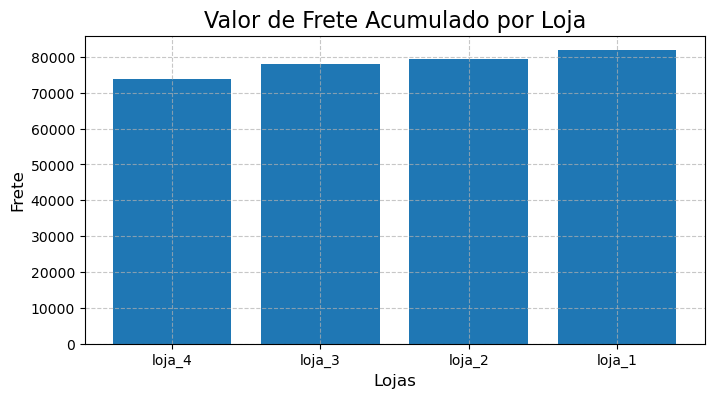

In [58]:
gerar_grafico_barras(df_temp, 'Loja', 'Frete', 'Valor de Frete Acumulado por Loja', 'Lojas', 'Frete', tamanho=(8,4))

In [59]:
df_temp = df_resumo_loja[['Loja', 'Frete', 'Perc_Frete_Faturamento']].sort_values(by='Frete', ascending=True)

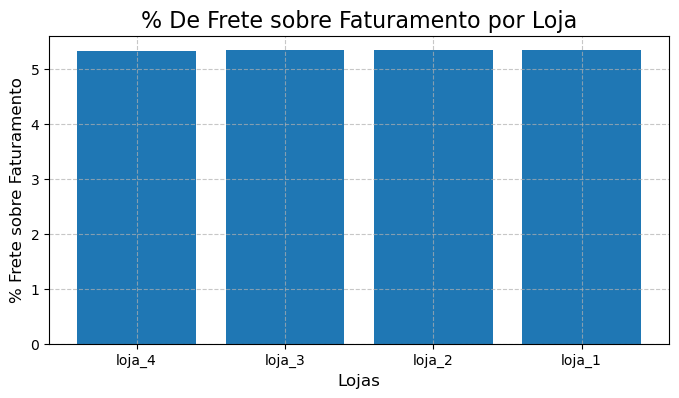

In [60]:
gerar_grafico_barras(df_temp, 'Loja', 'Perc_Frete_Faturamento', '% De Frete sobre Faturamento por Loja', 'Lojas', '% Frete sobre Faturamento', tamanho=(8,4))

# 7. Análise de indicadores por Loja e Estado

In [61]:
df_resumo_loja_estado = resumo_indicadores(df_lojas, nivel_detalhe=['Loja', 'Local da compra'], classificacao=['Faturamento'], ascendente=[False])

### Amostragem de dados

In [62]:
df_resumo_loja_estado.head()

,Loja,Local da compra,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
50,loja_2,SP,639945.6700,34142.2400,605803.4300,4.1360,116818.3360,985,39,649.6910,5.3352,10.8992,10.9105,10.8986
77,loja_3,SP,634081.2400,33828.0643,600253.1757,4.1607,118015.1280,983,39,645.0470,5.3350,10.7993,10.8101,10.7987
24,loja_1,SP,586673.2100,31246.0759,555427.1341,4.0894,114710.9860,984,39,596.2126,5.3260,9.9919,9.9850,9.9923
102,loja_4,SP,559106.8200,29756.0702,529350.7498,4.0686,109971.4060,991,39,564.1845,5.3221,9.5224,9.5088,9.5232
18,loja_1,RJ,230010.4400,12299.7851,217710.6549,3.6376,56150.5320,298,39,771.8471,5.3475,3.9174,3.9305,3.9167


### Ranking de Faturamento por Estado

In [63]:
detalhamento_categoria_dados(df_resumo_loja_estado, 'Local da compra', 'Faturamento')


Foram idetificados 27 valores distintos na categoria de dados Local da compra




,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
0,AC,loja_1,2320.4200,2196.5815,0.0000,2320.4200,82.7409
52,AC,loja_3,374.0800,353.2730,74.8160,374.0800,13.3388
26,AC,loja_2,109.9400,106.5016,65.9640,109.9400,3.9202


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
1,AL,loja_1,10703.3500,10120.7632,3619.0500,713.5567,41.4478
53,AL,loja_3,8669.0400,8212.6589,3705.7300,1238.4343,33.5701
27,AL,loja_2,4719.7500,4486.0978,1405.0300,363.0577,18.2768
79,AL,loja_4,1731.5300,1640.5699,985.0220,288.5883,6.7052


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
54,AM,loja_3,3477.6700,3293.9719,685.3220,1159.2233,44.3094
2,AM,loja_1,1495.2100,1420.1426,635.1880,498.4033,19.0507
28,AM,loja_2,1466.4400,1391.4618,4.7600,366.6100,18.6841
80,AM,loja_4,1409.2800,1331.8650,0.0000,352.3200,17.9558


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
81,AP,loja_4,2036.1400,1928.9657,120.2720,678.7133,53.8456
3,AP,loja_1,1309.5400,1243.5741,329.2420,327.3850,34.6307
55,AP,loja_3,435.7600,414.0842,28.1280,217.8800,11.5237


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
56,BA,loja_3,49024.0000,46410.8762,7326.5020,636.6753,27.8460
82,BA,loja_4,46163.6000,43708.4743,11721.6220,577.0450,26.2213
4,BA,loja_1,43877.3400,41506.5347,15401.3600,585.0312,24.9227
29,BA,loja_2,36988.8600,35048.1901,8877.6360,474.2162,21.0100


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
30,CE,loja_2,18438.6100,17445.2732,4178.3440,460.9653,26.0432
83,CE,loja_4,17624.5800,16688.8997,4834.1720,503.5594,24.8935
5,CE,loja_1,17597.9700,16634.0823,3792.5440,549.9366,24.8559
57,CE,loja_3,17138.8200,16256.3561,4689.2380,389.5186,24.2074


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
58,DF,loja_3,45525.9100,43086.9067,10220.3500,812.9627,33.3516
84,DF,loja_4,32516.3800,30759.4608,9170.2340,516.1330,23.8210
6,DF,loja_1,29729.2300,28130.2868,4502.5200,560.9289,21.7792
31,DF,loja_2,28731.3200,27221.2264,5501.4640,410.4474,21.0481


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
59,ES,loja_3,47107.7400,44563.5400,8499.2540,826.4516,44.0940
85,ES,loja_4,24655.8600,23363.9776,6269.2920,587.0443,23.0785
7,ES,loja_1,18620.7600,17634.2073,2500.1280,490.0200,17.4295
32,ES,loja_2,16450.3500,15595.7858,3090.6160,483.8338,15.3979


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
8,GO,loja_1,50505.4700,47776.6761,9660.4840,990.3033,38.1195
33,GO,loja_2,38655.9500,36585.1560,6019.5920,655.1856,29.1759
60,GO,loja_3,33554.1800,31787.9930,6343.9260,762.5950,25.3253
86,GO,loja_4,9777.0100,9250.6401,1070.9060,305.5316,7.3793


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
87,MA,loja_4,16344.3500,15476.7693,8194.6720,860.2289,39.9132
61,MA,loja_3,10498.1900,9942.7502,2485.8840,552.5363,25.6368
34,MA,loja_2,9992.2000,9460.1886,3658.9300,713.7286,24.4011
9,MA,loja_1,4115.0200,3892.0189,466.0060,411.5020,10.0489


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
35,MG,loja_2,190868.5400,180625.1113,33776.9380,674.4471,27.6295
62,MG,loja_3,168270.0000,159357.1549,31030.4140,590.4211,24.3582
88,MG,loja_4,165874.0100,157032.3106,30972.7600,616.6320,24.0114
10,MG,loja_1,165802.3700,156927.0034,18152.9140,625.6693,24.0010


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
89,MS,loja_4,17093.9500,16158.0021,1025.3360,633.1093,33.3021
11,MS,loja_1,11798.6100,11170.1298,4341.3180,655.4783,22.9858
63,MS,loja_3,11362.4300,10752.2526,333.9520,631.2461,22.1361
36,MS,loja_2,11074.9700,10486.6560,2613.3020,582.8932,21.5760


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
12,MT,loja_1,15444.5400,14624.4302,3719.8780,702.0245,31.7901
64,MT,loja_3,15118.7400,14293.9943,1725.8320,687.2155,31.1195
37,MT,loja_2,11553.0000,10936.5411,1718.6920,577.6500,23.7800
90,MT,loja_4,6466.5600,6112.5486,734.9420,404.1600,13.3104


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
91,PA,loja_4,14485.4700,13721.1271,6777.7680,852.0865,30.7049
65,PA,loja_3,14005.6500,13259.4656,2394.0240,538.6788,29.6878
13,PA,loja_1,12884.9200,12214.3811,4155.8000,585.6782,27.3122
38,PA,loja_2,5800.3900,5500.1425,286.3280,362.5244,12.2951


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
14,PB,loja_1,12737.7900,12063.7581,1603.5900,909.8421,43.1696
92,PB,loja_4,7539.7500,7141.8295,902.0060,538.5536,25.5530
39,PB,loja_2,6549.5100,6209.4718,1234.4460,545.7925,22.1969
66,PB,loja_3,2679.3200,2531.4196,754.1800,446.5533,9.0805


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
93,PE,loja_4,34079.7100,32252.3306,6079.4240,681.5942,28.2200
40,PE,loja_2,31860.4100,30140.7210,9657.9140,637.2082,26.3823
67,PE,loja_3,31385.1400,29730.8279,6392.2480,627.7028,25.9888
15,PE,loja_1,23439.0200,22174.9048,4055.5520,756.0974,19.4089


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
94,PI,loja_4,12273.7500,11635.1039,3561.0720,681.8750,44.0487
68,PI,loja_3,5812.6700,5513.6167,1209.9160,581.2670,20.8608
41,PI,loja_2,5119.0500,4830.8824,1309.5040,853.1750,18.3715
16,PI,loja_1,4658.5800,4406.4909,101.5020,776.4300,16.7190


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
17,PR,loja_1,94643.6600,89676.2426,16656.7140,739.4036,30.7527
69,PR,loja_3,74798.7200,70802.8653,13353.6360,623.3227,24.3045
95,PR,loja_4,74354.8800,70346.7633,13878.0920,585.4715,24.1602
42,PR,loja_2,63959.9000,60579.9936,6941.2580,652.6520,20.7826


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
18,RJ,loja_1,230010.4400,217710.6549,56150.5320,771.8471,29.8168
43,RJ,loja_2,205460.9700,194555.9075,43056.2180,660.6462,26.6344
96,RJ,loja_4,170103.4700,161055.6835,41501.0240,552.2840,22.0509
70,RJ,loja_3,165838.0200,156960.6664,39773.6800,562.1628,21.4980


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
97,RN,loja_4,11682.0800,11051.9049,1154.4960,730.1300,32.5894
44,RN,loja_2,10517.4500,9957.8435,1186.5260,809.0346,29.3405
19,RN,loja_1,7257.6600,6855.7424,2441.2940,806.4067,20.2467
71,RN,loja_3,6389.0200,6056.3518,1162.9740,638.9020,17.8234


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
20,RO,loja_1,5501.2700,5211.8297,232.3880,1100.2540,33.4963
98,RO,loja_4,4198.7100,3960.0490,431.4400,1049.6775,25.5652
72,RO,loja_3,3735.9000,3545.4187,745.1120,622.6500,22.7473
45,RO,loja_2,2987.6400,2825.6250,1995.4640,746.9100,18.1912


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
46,RR,loja_2,3229.4200,3059.8787,1291.7680,3229.4200,76.9314
73,RR,loja_3,968.3700,910.5653,387.3480,968.3700,23.0686


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
21,RS,loja_1,111347.0500,105436.9684,21800.0500,718.3681,30.2893
47,RS,loja_2,93717.2300,88716.5200,11870.4880,755.7841,25.4935
99,RS,loja_4,91628.5800,86763.2792,17751.1460,721.4849,24.9254
74,RS,loja_3,70918.9200,67160.0070,11873.8600,554.0541,19.2918


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
100,SC,loja_4,60857.3600,57655.3747,9882.3520,760.7170,31.3050
22,SC,loja_1,56332.0900,53345.1279,10238.5960,592.9694,28.9772
48,SC,loja_2,40981.1600,38795.6372,13058.6780,435.9698,21.0807
75,SC,loja_3,36231.0800,34281.2919,6558.5480,470.5335,18.6372


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
23,SE,loja_1,6154.0700,5830.9949,2506.1200,439.5764,37.7004
76,SE,loja_3,5307.0100,5032.2083,1248.7280,758.1443,32.5112
49,SE,loja_2,4484.2700,4246.8087,1653.6640,1121.0675,27.4710
101,SE,loja_4,378.2800,359.9805,68.1160,126.0933,2.3174


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
50,SP,loja_2,639945.6700,605803.4300,116818.3360,649.6910,26.4461
77,SP,loja_3,634081.2400,600253.1757,118015.1280,645.0470,26.2038
24,SP,loja_1,586673.2100,555427.1341,114710.9860,596.2126,24.2446
102,SP,loja_4,559106.8200,529350.7498,109971.4060,564.1845,23.1054


,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
25,TO,loja_1,9549.5300,9040.4915,1036.9640,868.1391,53.7140
51,TO,loja_2,4796.0600,4533.8503,1015.8320,799.3433,26.9768
103,TO,loja_4,2115.4700,1995.0450,886.1940,302.2100,11.8991
78,TO,loja_3,1317.4100,1238.6769,251.7220,263.4820,7.4101




Loja líder de Faturamento em cada uma das categorias de dados da coluna Local da compra



,Local da compra,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
0,AC,loja_1,2320.4200,2196.5815,0.0000,2320.4200,82.7409
1,AL,loja_1,10703.3500,10120.7632,3619.0500,713.5567,41.4478
54,AM,loja_3,3477.6700,3293.9719,685.3220,1159.2233,44.3094
81,AP,loja_4,2036.1400,1928.9657,120.2720,678.7133,53.8456
56,BA,loja_3,49024.0000,46410.8762,7326.5020,636.6753,27.8460
30,CE,loja_2,18438.6100,17445.2732,4178.3440,460.9653,26.0432
58,DF,loja_3,45525.9100,43086.9067,10220.3500,812.9627,33.3516
59,ES,loja_3,47107.7400,44563.5400,8499.2540,826.4516,44.0940
8,GO,loja_1,50505.4700,47776.6761,9660.4840,990.3033,38.1195
87,MA,loja_4,16344.3500,15476.7693,8194.6720,860.2289,39.9132




Consolidado por Loja líder de Faturamento em cada uma das categorias de dados da coluna Local da compra



,Loja,Quantidade,Faturamento
0,loja_1,11,548917.5900
3,loja_4,8,168852.8100
1,loja_2,4,852482.2400
2,loja_3,4,145135.3200


# 8. Análise de indicadores por Loja e Tipo de Pagamento

In [64]:
df_resumo_loja_tipo_pag = resumo_indicadores(df_lojas, nivel_detalhe=['Loja', 'Tipo de pagamento'], classificacao=['Faturamento'], ascendente=[False])

### Amostragem de dados

In [65]:
df_resumo_loja_tipo_pag.head()

,Loja,Tipo de pagamento,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
1,loja_1,cartao_credito,1120887.6600,59785.5428,1061102.1172,3.9589,224168.4080,1704,39,657.7979,5.3338,19.0903,19.1050,19.0895
5,loja_2,cartao_credito,1088879.3100,58031.7686,1030847.5414,4.0308,209203.4500,1721,39,632.7015,5.3295,18.5452,18.5446,18.5452
9,loja_3,cartao_credito,1072760.4700,57240.6903,1015519.7797,4.0302,206411.1180,1753,39,611.9569,5.3358,18.2707,18.2918,18.2695
13,loja_4,cartao_credito,1024944.6000,54712.9186,970231.6814,3.9703,217387.5960,1720,39,595.8980,5.3381,17.4563,17.4840,17.4547
0,loja_1,boleto,310147.0900,16459.9030,293687.1870,4.0973,52845.8940,483,39,642.1265,5.3071,5.2823,5.2599,5.2835


### Ranking de Faturamento por Tipo de Pagamento

In [66]:
detalhamento_categoria_dados(df_resumo_loja_tipo_pag, 'Tipo de pagamento', 'Faturamento')


Foram idetificados 4 valores distintos na categoria de dados Tipo de pagamento




,Tipo de pagamento,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
0,boleto,loja_1,310147.0900,293687.1870,52845.8940,642.1265,26.4124
8,boleto,loja_3,305762.6700,289525.4338,58212.1960,653.3390,26.0391
4,boleto,loja_2,280998.4500,266047.4003,49587.0600,601.7097,23.9301
12,boleto,loja_4,277337.9700,262668.6788,53717.0180,575.3900,23.6184


,Tipo de pagamento,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
1,cartao_credito,loja_1,1120887.6600,1061102.1172,224168.4080,657.7979,26.0219
5,cartao_credito,loja_2,1088879.3100,1030847.5414,209203.4500,632.7015,25.2788
9,cartao_credito,loja_3,1072760.4700,1015519.7797,206411.1180,611.9569,24.9046
13,cartao_credito,loja_4,1024944.6000,970231.6814,217387.5960,595.8980,23.7946


,Tipo de pagamento,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
10,cartao_debito,loja_3,22286.7000,21098.9029,4693.0060,602.3432,29.6061
14,cartao_debito,loja_4,19566.7300,18537.1620,3128.0700,631.1848,25.9928
2,cartao_debito,loja_1,17999.0500,16992.9548,4433.6100,514.2586,23.9103
6,cartao_debito,loja_2,15424.9900,14615.5263,3322.0460,514.1663,20.4908


,Tipo de pagamento,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
7,cupom,loja_2,103156.3100,97634.4340,20175.1360,731.6050,32.8006
3,cupom,loja_1,85475.3200,80888.8931,21362.8080,623.9074,27.1786
11,cupom,loja_3,63215.1900,59858.2524,11954.1320,625.8930,20.1005
15,cupom,loja_4,62648.2800,59304.1827,13711.0820,501.1862,19.9203




Loja líder de Faturamento em cada uma das categorias de dados da coluna Tipo de pagamento



,Tipo de pagamento,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
0,boleto,loja_1,310147.0900,293687.1870,52845.8940,642.1265,26.4124
1,cartao_credito,loja_1,1120887.6600,1061102.1172,224168.4080,657.7979,26.0219
10,cartao_debito,loja_3,22286.7000,21098.9029,4693.0060,602.3432,29.6061
7,cupom,loja_2,103156.3100,97634.4340,20175.1360,731.6050,32.8006




Consolidado por Loja líder de Faturamento em cada uma das categorias de dados da coluna Tipo de pagamento



,Loja,Quantidade,Faturamento
0,loja_1,2,1431034.7500
1,loja_2,1,103156.3100
2,loja_3,1,22286.7000


# 9. Análise de indicadores por Loja e Mês do Ano

In [67]:
df_resumo_loja_mes = resumo_indicadores(df_lojas, nivel_detalhe=['Loja', 'Nome mês'], classificacao=['Faturamento'], ascendente=[False])

### Amostragem de dados

In [68]:
df_resumo_loja_mes.head()

,Loja,Nome mês,Faturamento,Frete,Receita,Media_avaliacao,Custo_avaliacao,Quant_compras,Quant_meses,Faturamento_medio,Perc_Frete_Faturamento,Perc_Part_Faturamento,Perc_Part_Frete,Perc_Part_Receita
3,loja_1,February,183599.5000,9821.5773,173777.9227,3.8710,43216.4080,248,4,740.3206,5.3495,3.1270,3.1386,3.1263
16,loja_2,January,168149.2200,9051.0100,159098.2100,4.0239,34357.9480,251,4,669.9172,5.3827,2.8638,2.8923,2.8622
7,loja_1,March,164507.4600,8771.8075,155735.6525,3.9283,31524.6240,265,4,620.7829,5.3322,2.8018,2.8031,2.8017
43,loja_4,March,154219.6700,8107.6431,146112.0269,4.0833,28164.5340,252,4,611.9828,5.2572,2.6266,2.5909,2.6286
4,loja_1,January,151735.9100,8135.1232,143600.7868,3.9375,30215.7200,240,4,632.2330,5.3614,2.5843,2.5997,2.5834


### Ranking de Faturamento por Mês do Ano

In [69]:
detalhamento_categoria_dados(df_resumo_loja_mes, 'Nome mês', 'Faturamento')


Foram idetificados 12 valores distintos na categoria de dados Nome mês




,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
36,April,loja_4,133903.1300,126763.1429,32711.4160,650.0152,27.6772
12,April,loja_2,126984.4200,120252.1122,19770.2420,725.6253,26.2471
24,April,loja_3,117999.0800,111682.4491,21373.3220,666.6615,24.3899
0,April,loja_1,104916.2700,99352.2153,14067.8920,596.1152,21.6857


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
1,August,loja_1,125057.2600,118385.2268,18739.8620,710.5526,26.7589
25,August,loja_3,118048.0700,111767.9672,26857.2020,614.8337,25.2591
13,August,loja_2,112407.1900,106423.7491,21810.9500,649.7525,24.0521
37,August,loja_4,111836.3400,105799.6016,23239.6640,591.7267,23.9299


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
26,December,loja_3,148235.8000,140354.1373,31971.2460,726.6461,30.2044
14,December,loja_2,130982.1000,124043.0531,23442.3860,654.9105,26.6888
2,December,loja_1,114339.5900,108224.3173,19593.9540,601.7873,23.2977
38,December,loja_4,97218.5200,92002.7552,22781.3700,555.5344,19.8091


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
3,February,loja_1,183599.5000,173777.9227,43216.4080,740.3206,31.5758
39,February,loja_4,141299.5700,133800.5862,33197.2740,560.7126,24.3009
15,February,loja_2,136273.5300,129011.4322,24025.2960,661.5220,23.4366
27,February,loja_3,120284.4000,113896.1078,22527.1740,562.0766,20.6867


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
16,January,loja_2,168149.2200,159098.2100,34357.9480,669.9172,28.2441
4,January,loja_1,151735.9100,143600.7868,30215.7200,632.2330,25.4871
28,January,loja_3,146216.2100,138364.7708,26050.6500,573.3969,24.5600
40,January,loja_4,129242.3700,122317.7732,24099.6800,540.7631,21.7089


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
5,July,loja_1,132286.1700,125265.9671,19576.2780,707.4127,28.4575
29,July,loja_3,121237.5500,114774.4288,25531.6480,628.1738,26.0807
17,July,loja_2,109054.1200,103222.1767,26679.8240,605.8562,23.4598
41,July,loja_4,102276.9200,96819.0542,19975.2240,587.7984,22.0019


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
6,June,loja_1,109456.1200,103634.4710,21044.3620,651.5245,27.7263
30,June,loja_3,100021.1600,94700.1958,18623.0220,561.9166,25.3363
18,June,loja_2,96839.7400,91718.1746,21392.6800,612.9097,24.5304
42,June,loja_4,88457.0800,83750.8351,20681.7800,567.0326,22.4070


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
7,March,loja_1,164507.4600,155735.6525,31524.6240,620.7829,27.4455
43,March,loja_4,154219.6700,146112.0269,28164.5340,611.9828,25.7291
19,March,loja_2,141197.0200,133715.9033,23953.9040,528.8278,23.5565
31,March,loja_3,139473.5500,132047.8131,30246.4920,542.6986,23.2689


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
8,May,loja_1,121977.1500,115497.4991,28831.9260,709.1695,27.1088
20,May,loja_2,117412.8100,111113.5560,17085.1640,659.6225,26.0944
32,May,loja_3,112723.3500,106737.8392,17910.5180,704.5209,25.0522
44,May,loja_4,97840.9500,92628.4705,17254.1900,534.6500,21.7446


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
33,November,loja_3,135885.3500,128622.5593,28200.4820,734.5154,29.7588
45,November,loja_4,121572.2300,115093.1527,22200.3320,560.2407,26.6242
21,November,loja_2,106234.5800,100546.5565,20456.6220,586.9314,23.2653
9,November,loja_1,92930.1400,87976.5083,21449.0480,549.8825,20.3516


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
22,October,loja_2,117283.1500,111074.3364,28714.9440,630.5546,29.4704
34,October,loja_3,110387.8500,104508.1773,16757.6100,623.6602,27.7378
46,October,loja_4,85828.1100,81277.5856,19444.4940,591.9180,21.5665
10,October,loja_1,84469.5700,79914.8651,26419.9920,548.5037,21.2252


,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
11,September,loja_1,149233.9800,141305.7203,28130.6540,697.3550,30.5063
23,September,loja_2,125641.1800,118925.6419,20597.7320,615.8881,25.6835
47,September,loja_4,120802.6900,114376.7208,24193.8080,710.6041,24.6944
35,September,loja_3,93512.6600,88545.9230,15221.0860,559.9560,19.1158




Loja líder de Faturamento em cada uma das categorias de dados da coluna Nome mês



,Nome mês,Loja,Faturamento,Receita,Custo_avaliacao,Faturamento_medio,Perc_Faturamento
36,April,loja_4,133903.1300,126763.1429,32711.4160,650.0152,27.6772
1,August,loja_1,125057.2600,118385.2268,18739.8620,710.5526,26.7589
26,December,loja_3,148235.8000,140354.1373,31971.2460,726.6461,30.2044
3,February,loja_1,183599.5000,173777.9227,43216.4080,740.3206,31.5758
16,January,loja_2,168149.2200,159098.2100,34357.9480,669.9172,28.2441
5,July,loja_1,132286.1700,125265.9671,19576.2780,707.4127,28.4575
6,June,loja_1,109456.1200,103634.4710,21044.3620,651.5245,27.7263
7,March,loja_1,164507.4600,155735.6525,31524.6240,620.7829,27.4455
8,May,loja_1,121977.1500,115497.4991,28831.9260,709.1695,27.1088
33,November,loja_3,135885.3500,128622.5593,28200.4820,734.5154,29.7588




Consolidado por Loja líder de Faturamento em cada uma das categorias de dados da coluna Nome mês



,Loja,Quantidade,Faturamento
0,loja_1,7,986117.6400
1,loja_2,2,285432.3700
2,loja_3,2,284121.1500
3,loja_4,1,133903.1300


# 10. Relatório final

## Com base nas análises realizadas nos dados fornecidos, a indicação é que seja vendida a Loja 4

### Abaixo detalhamento da análise

> Os dados fornecidos compreendem o período de janeiro de 2020 à março de 2023

### Ranking de Faturamento
> Embora no ano de 2020 a Loja estivesse em 2° lugar nas vendas, nos anos de 2021 e 2022, ficou em último lugar e aponta para mesma situação nos três primeiros meses de 2023
>
> Nos últimos 12 meses loja teve a pior faturamento em 8 meses
>
> A loja tem o pior Faturamento médio acumulado
>
> Em relação as categorias, a loja tem pior desempenho em 4 das 8 categorias de produtos no Faturamento acumulado
>
> Em relação aos meses do ano, a loja só é líder de Faturamento no mês de Abril e tem o pior resultado em 6 dos 12 meses do ano


### Variação de Faturamento em relação ao ano anterior
> Em 2021 a loja foi a 3° colocada em % de variação de faturamento em relação ao ano anterior
>
> Nos demais anos, a loja apresenta a pior variação em relação ao ano anterior

### Avaliação dos Compradores
> Na média consolidada a loja está em 3° lugar na avaliação de compra dos clientes
>
> Mesmo considerando uma métrica ponderada da avaliação pelo faturamento, a loja também está em 3° lugar na avaliação ponderada

### Vendas por Produtos
> Considerando top 20 de da venda acumulada de produtos, a loja está em último lugar


### Ranking de Receitas
> Foi criado um ranking de Receita considerando o valor do Faturamento menos Frete. Embora a loja tenho uma vantagem muito pequena em relação ao % de Frete, é a última colocada em Receitas


## Exceções de desempenho

### Embora a loja 4 de um modo geral tenha desempenho abaixo das demais lojas nos indicadores analisados, foram identificadas algumas exceções

### Vendas por Produtos
> Considerando top 100 da venda acumulada de produtos, a loja está em primeiro lugar juntamente com a Loja 3


### Frete das Compras
> Embora quase todas as lojas estejam empatadas, a loja apresenta uma pequena liderança no % de Frete sobre o Faturamento

### Ranking de Faturamento
> A loja tem melhor desempenho em 2 das 8 categorias de produtos no Faturamento acumulado
